## 决策树

决策树是一种简单但功能强大的监督学习问题模型。顾名思义，我们可以把决策树看成是一棵树，信息沿着不同分支流动——从主干开始，一直到单个的叶子，在每个交叉点对选择哪个分支进行决策。

构建决策树的一个真正难点是，如何从数据中提取合适的特征。

假设，我们有一个数据集是由单个电子邮件组成的：

In [1]:
data = [
    'I am Mohammed Abacha, the son of the late Nigerian Head of '
    'State who died on the 8th of June 1998. Since i have been '
    'unsuccessful in locating the relatives for over 2 years now '
    'I seek your consent to present you as the next of kin so '
    'that the proceeds of this account valued at US$15.5 Million '
    'Dollars can be paid to you. If you are capable and willing '
    'to assist, contact me at once via email with following '
    'details: 1. Your full name, address, and telephone number. '
    '2. Your Bank Name, Address. 3.Your Bank Account Number and '
    'Beneficiary Name - You must be the signatory.'
]
from sklearn.feature_extraction.text import CountVectorizer
vec = CountVectorizer()
X = vec.fit_transform(data)
# 查看X中的特征名称
vec.get_feature_names()[:5]

['15', '1998', '8th', 'abacha', 'account']

为了清晰起见，我们只关注前5个单词，它们是按照字母顺序排列的。对应的出现次数如下所示：

In [2]:
X.toarray()[0, :5]

array([1, 1, 1, 1, 2], dtype=int64)

这告诉我们，在这封邮件中，4/5的单词只出现了1次，可是单词account实际上出现了2次。

那么，我们如何检查电子邮件是否来自Nigerian prince呢？

一种方法是查看邮件中是否包含nigerian和prince这2个单词：

In [3]:
'nigerian' in vec.get_feature_names()

True

In [4]:
'prince' in vec.get_feature_names()

False

在邮件中并没有出现prince这个单词，而是出现了词组head of state，有效地避开了我们过于简单的垃圾邮件检测器。

类似地，我们如何开始建模树中的第二个决策“wants me to send himmoney”？文本中没有直接的特征可以回答这个问题。因此，这是特征工程的一个问题，将邮件信息中实际出现的单词组合在一起，以使我们能够回答这个问题。当然，一个好的迹象是查找诸如US$和money这样的字符串，但是我们仍然不知道涉及这些单词的上下文。据我们所知，这些单词可能是句子“Don't worry, I don'twant you to send me any money”的一部分。

更糟糕的是，事实证明，我们问这些问题的顺序实际上会影响最终的结果。例如，如果我们先问最后一个问题“do I actually know a Nigerian prince?”会怎样呢？假设我们有一个叔叔是尼日利亚王子（Nigerian prince），那么在电子邮件中找到Nigerian prince这个词可能就没什么值得怀疑的了。

这个看似简单的例子很快就失控了，决策树背后的理论框架有助于我们找到正确的决策规则以及下一步应该执行的决策。

## 构建一棵决策树

让我们考虑一个例子，其中有几个病人患有相同的疾病，例如，一种罕见的基底神经性厌食症。让我们进一步假设这种疾病的真正原因直到今天仍是未知的，我们可以得到的所有信息都是由一系列生理测量组成的。例如，我们可以获得以下信息：
* 病人的血压（BP）。
* 病人的胆固醇水平（cholesterol）。
* 病人的性别（sex）。病人的年龄（age）。
* 病人血液中的钠浓度（Na）。
* 病人血液中的钾浓度（K）。

基于所有这些信息，假设医生建议患者使用4种可能药品中的一种来治疗他们的疾病：药品A、B、C或者D。我们有20个不同患者的数据（输出已经过修剪）：

In [5]:
data = [
    {'age': 33, 'sex': 'F', 'BP': 'high', 'cholesterol': 'high', 'Na': 0.66, 'K': 0.06, 'drug': 'A'},
    {'age': 77, 'sex': 'F', 'BP': 'high', 'cholesterol': 'normal', 'Na': 0.19, 'K': 0.03, 'drug': 'D'},
    {'age': 88, 'sex': 'M', 'BP': 'normal', 'cholesterol': 'normal', 'Na': 0.80, 'K': 0.05, 'drug': 'B'},
    {'age': 39, 'sex': 'F', 'BP': 'low', 'cholesterol': 'normal', 'Na': 0.19, 'K': 0.02, 'drug': 'C'},
    {'age': 43, 'sex': 'M', 'BP': 'normal', 'cholesterol': 'high', 'Na': 0.36, 'K': 0.03, 'drug': 'D'},
    {'age': 82, 'sex': 'F', 'BP': 'normal', 'cholesterol': 'normal', 'Na': 0.09, 'K': 0.09, 'drug': 'C'},
    {'age': 40, 'sex': 'M', 'BP': 'high', 'cholesterol': 'normal', 'Na': 0.89, 'K': 0.02, 'drug': 'A'},
    {'age': 88, 'sex': 'M', 'BP': 'normal', 'cholesterol': 'normal', 'Na': 0.80, 'K': 0.05, 'drug': 'B'},
    {'age': 29, 'sex': 'F', 'BP': 'high', 'cholesterol': 'normal', 'Na': 0.35, 'K': 0.04, 'drug': 'D'},
    {'age': 53, 'sex': 'F', 'BP': 'normal', 'cholesterol': 'normal', 'Na': 0.54, 'K': 0.06, 'drug': 'C'},
    {'age': 36, 'sex': 'F', 'BP': 'high', 'cholesterol': 'high', 'Na': 0.53, 'K': 0.05, 'drug': 'A'},
    {'age': 63, 'sex': 'M', 'BP': 'low', 'cholesterol': 'high', 'Na': 0.86, 'K': 0.09, 'drug': 'B'},
    {'age': 60, 'sex': 'M', 'BP': 'low', 'cholesterol': 'normal', 'Na': 0.66, 'K': 0.04, 'drug': 'C'},
    {'age': 55, 'sex': 'M', 'BP': 'high', 'cholesterol': 'high', 'Na': 0.82, 'K': 0.04, 'drug': 'B'},
    {'age': 35, 'sex': 'F', 'BP': 'normal', 'cholesterol': 'high', 'Na': 0.27, 'K': 0.03, 'drug': 'D'},
    {'age': 23, 'sex': 'F', 'BP': 'high', 'cholesterol': 'high', 'Na': 0.55, 'K': 0.08, 'drug': 'A'},
    {'age': 49, 'sex': 'F', 'BP': 'low', 'cholesterol': 'normal', 'Na': 0.27, 'K': 0.05, 'drug': 'C'},
    {'age': 27, 'sex': 'M', 'BP': 'normal', 'cholesterol': 'normal', 'Na': 0.77, 'K': 0.02, 'drug': 'B'},
    {'age': 51, 'sex': 'F', 'BP': 'low', 'cholesterol': 'high', 'Na': 0.20, 'K': 0.02, 'drug': 'D'},
    {'age': 38, 'sex': 'M', 'BP': 'high', 'cholesterol': 'normal', 'Na': 0.78, 'K': 0.05, 'drug': 'A'}
]

### 1. 生成新数据

所有的机器学习和深度学习技术都需要大量的数据——简单来说就是越多越好。但是如果没有足够的数据呢？你可能会得到一个不够准确的模型。常见的技术（如果你不能够生成任何新数据）是使用大量的数据进行训练。这样做的主要问题是，你的模型不具有泛化能力，或者说你的模型是过拟合的。

解决上述问题的一个方法是生成新数据，这就是通常所说的合成数据。这里要注意的关键点是，合成的数据应该与你的实际数据有相似的特征。合成的数据和实际数据越相似，对作为机器学习工程师的你也就越有利。这种技术称为数据增广（dataaugmentation），我们使用旋转和镜像图像等各种技术基于现有数据生成新数据。

*在多数情况下，常识和深度学习并不能很好地结合在一起。这是因为你希望你的模型能够理解什么是异常值。例如，你知道一个人的年龄不大可能是130岁，但是一个通用模型应该理解这个值是一个异常值，不应该将这个值考虑进去。这就是为什么我们总是有一小部分数据具有这种不合逻辑的值。*

### 2. 通过理解数据来理解任务

首先要意识到的是，drug列实际上与其他列的特征值并不一样。因为我们的目标是根据患者的血压值预测开哪种药品，drug列实际上成了目标标签。或者说，我们的机器学习算法的输入是患者的血压值、年龄和性别。而输出是对处方药品的一个预测。drug列本质上是类别，而不是数值，我们知道我们面对的正是一个分类任务。

因此，最好将data变量中列出的所有drug项都从字典中删除，并将它们存储到一个独立的变量中：

Text(0, 0.5, 'potassium')

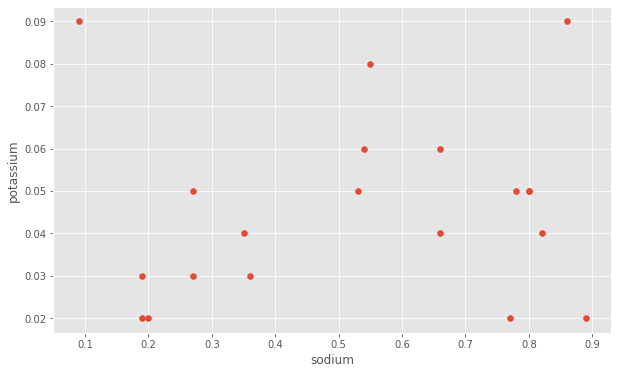

In [6]:
target = [d['drug'] for d in data]
[d.pop('drug') for d in data];
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
age = [d['age'] for d in data]
sodium = [d['Na'] for d in data]
potassium = [d['K'] for d in data]
plt.figure(figsize=(10, 6))
plt.scatter(sodium, potassium)
plt.xlabel('sodium')
plt.ylabel('potassium')
# 钾浓度与钠浓度图

这个图提供的信息不是很多，因为所有的数据点都是相同的颜色。我们真正希望的是根据处方药品为每个数据点着色。为此，我们需要以某种方式将药品标签（从A到D）转换成数值。一个很好的技巧是使用字符的ASCII值。

在Python中，这个值可以通过ord函数访问。例如，字符A的值是65（即ord('A')==65），字符B的值是66，字符C的值是67，字符D的值是68。因此，我们可以通过调用ord并从每个ASCII值中减去65，将字符A到D转换为0到3之间的整数。我们对数据集中的每个元素都这样做，就像前面使用列表理解一样：

Text(0, 0.5, 'sodium (Na)')

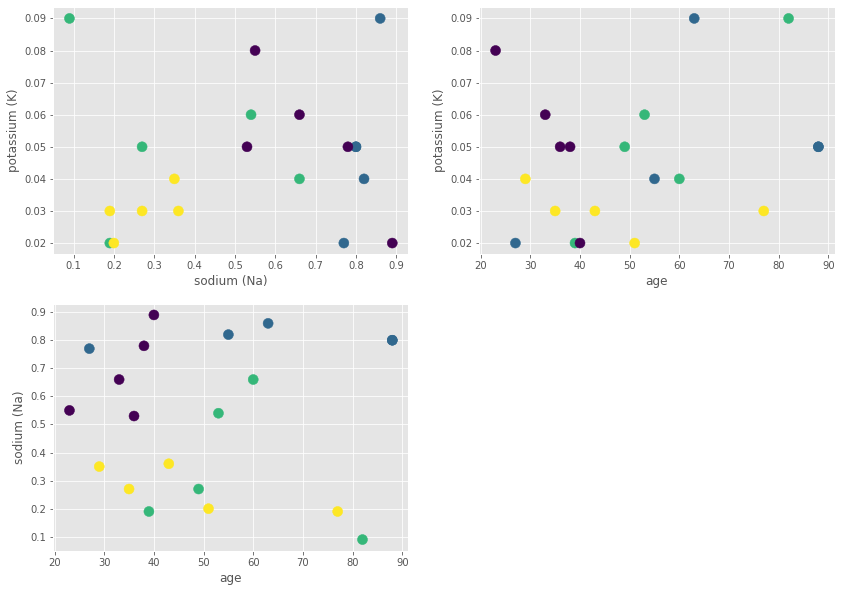

In [7]:
target = [ord(t) - 65 for t in target]
plt.figure(figsize=(14, 10))

plt.subplot(221)
plt.scatter([d['Na'] for d in data], [d['K'] for d in data],
            c=target, s=100)
plt.xlabel('sodium (Na)')
plt.ylabel('potassium (K)')

plt.subplot(222)
plt.scatter([d['age'] for d in data], [d['K'] for d in data],
            c=target, s=100)
plt.xlabel('age')
plt.ylabel('potassium (K)')

plt.subplot(223)
plt.scatter([d['age'] for d in data], [d['Na'] for d in data],
            c=target, s=100)
plt.xlabel('age')
plt.ylabel('sodium (Na)')

### 3. 数据处理

为了让决策树算法理解数据，我们需要将所有的类别特征（sex、BP和cholesterol）转换成数值特征。

In [8]:
from sklearn.feature_extraction import DictVectorizer
vec = DictVectorizer(sparse=False)
data_pre = vec.fit_transform(data)
vec.get_feature_names()

['BP=high',
 'BP=low',
 'BP=normal',
 'K',
 'Na',
 'age',
 'cholesterol=high',
 'cholesterol=normal',
 'sex=F',
 'sex=M']

In [9]:
data_pre[0]

array([ 1.  ,  0.  ,  0.  ,  0.06,  0.66, 33.  ,  1.  ,  0.  ,  1.  ,
        0.  ])

要确保我们的数据变量与OpenCV兼容，我们需要将所有数据变量转换成浮点值：

In [10]:
import numpy as np
data_pre = np.array(data_pre, dtype=np.float32)
target = np.array(target, dtype=np.float32).reshape((-1, 1))

接下来，剩下要做的就是将数据拆分成训练集和测试集。

In [11]:
import sklearn.model_selection as ms
X_train, X_test, y_train, y_test = ms.train_test_split(
    data_pre, target, test_size=5, random_state=42
)

### 4. 构建树

#### 1）使用下面的代码，我们可以创建一棵空的决策树：

In [12]:
import cv2
dtree = cv2.ml.DTrees_create()
# 在训练模型之前，我们将对树的默认参数做一点修改。
dtree.setCVFolds(0) # 默认值为10，非零值会导致核心转储
dtree.setMaxDepth(8) # 默认值为INT_MAX

#### 2）要在训练数据上训练决策树，我们使用train方法。这就是为什么我们要将数据转换成浮点——这样就可以在train方法中使用它了：

In [13]:
dtree.train(X_train, cv2.ml.ROW_SAMPLE, y_train)

True

必须指定X_train中的数据样本是否占用行（使用cv2.ml.ROW_SAMPLE）或者列（cv2.ml.COL_SAMPLE）。

#### 3）接下来，我们用predict可以预测新数据点的标签：

In [14]:
_,y_pred = dtree.predict(X_test)

#### 4）如果我们想要知道算法的性能，可以再次使用scikit-learn的accuracy score：

In [15]:
from sklearn import metrics
metrics.accuracy_score(y_test, y_pred.round())

0.2

In [16]:
_,y_pred_train = dtree.predict(X_train)
metrics.accuracy_score(y_train, y_pred_train.round())

0.4666666666666667

决策树往往能够很好地学习训练集，但是却不能够泛化新的数据点，这也称为过拟合。

让我们考虑这样一种情况：只有在汽车前方出现障碍（人或者物体）时，该模型才接受减速或者加速的训练。如果在训练时障碍物的大小被认为接近一个成年人的大小，那么模型就无法检测到小孩，因此汽车也不会减速。即使与其他项相比，在训练集中该项数量很低，也会出现这种情况。这是一个典型的过拟合例子。

模型记住了这些值和正确的结果，可是并没有学到太多内容。这样的模型在训练集上表现得很好，但是在遇到任何新的、不同的数据时却表现得很差。这使得模型的泛化能力很差。

## 可视化一棵经过训练的决策树

我们将转向scikit-learn。scikit-learn的实现允许我们自定义算法，而且使对树的内部工作方式的研究变得更加容易。它的用法也有更好的文档说明。

### 1）首先，让我们从sklearn导入tree模块：

In [17]:
from sklearn import tree

### 2）与OpenCV类似，我们使用DecisionTreeClassifier构造函数创建一棵空的决策树：

In [18]:
dtc = tree.DecisionTreeClassifier()

### 3）使用fit方法对树进行训练：

In [19]:
dtc.fit(X_train, y_train)

DecisionTreeClassifier()

### 4）使用score方法，我们可以计算训练集和测试集的准确率得分：

In [20]:
dtc.score(X_train, y_train), dtc.score(X_test, y_test)

(1.0, 0.4)

### 5）再回到Python，你可以使用scikit-learn的export_graphviz导出器，以GraphViz格式把树导出到一个tree.dot文件：

In [21]:
with open("tree.dot", 'w') as f:
    f = tree.export_graphviz(dtc, out_file=f,
                            feature_names=vec.get_feature_names(),
                            class_names=['A', 'B', 'C', 'D'])

### 6）然后，回到命令行，你可以使用GraphViz把tree.dot转换为一个（例如）PNG文件：

`dot -Tpng tree.dot -o tree.png`

## 评估特征的重要性

scikit-learn提供了一个函数，用来评估特征重要性，它对于每个特征是0和1之间的一个数，0表示在做任何决策时根本就没有使用，1表示完全预测了目标。归一化特征的重要性，以便所有的特征重要性之和为1。

In [22]:
dtc.feature_importances_

array([0.        , 0.        , 0.        , 0.        , 0.43273092,
       0.24096386, 0.32630522, 0.        , 0.        , 0.        ])

如果我们提示特征名称，那么就会清楚哪个特征似乎是最重要的。图可能能提供最多的有用信息：

<BarContainer object of 10 artists>

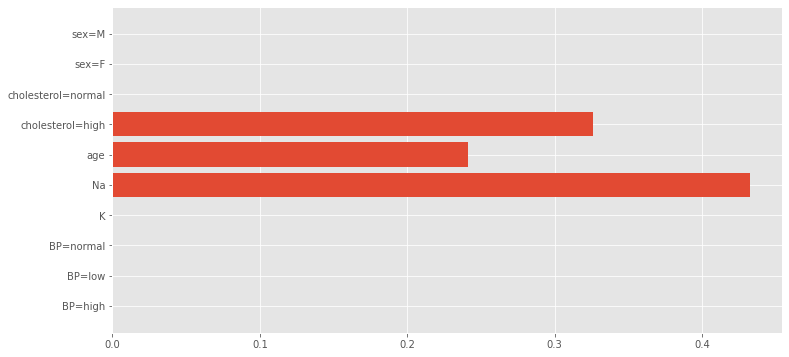

In [23]:
plt.figure(figsize=(12, 6))
plt.barh(range(10), dtc.feature_importances_, align='center', tick_label=vec.get_feature_names())

现在，很明显，知道给病人开哪种药品的最重要特征实际上是病人的胆固醇浓度是否正常。年龄、钠浓度和钾浓度也很重要。另外，性别和血压似乎没有任何区别。可是，这并不表示性别或者血压不重要。这只表示决策树没有选择这些特征，很可能是因为另一个特征会产生相同的拆分。

## 理解决策规则

scikit-learn支持的两个最常用的标准如下所示：
* criterion='gini'：基尼不纯度是一种误分类的度量，目标是最小化误分类的概率。数据的完美拆分（每个子组包含一个目标标签的数据点）产生的基尼系数为0。我们可以度量树的每种可能拆分的基尼系数，然后选择基尼不纯度最低的那个。它常用于分类和回归树。
* criterion='entropy'（也称为信息增益）：在信息论中，熵是与信号或者分布相关的不确定量的度量。一个完美的数据拆分熵为0。我们可以度量树的每种可能拆分的熵，然后选择熵最低的那个。

在scikit-learn中，可以在决策树调用的构造函数中指定拆分标准。例如，如果想使用熵，那么要输入以下内容：

`dtce = tree.DecisionTreeClassifier(criterion='entropy')`

## 控制决策树的复杂度

如果你继续生成一棵树，直到所有的叶子节点都是纯的，那么通常你会得到一棵过于复杂且无法解释的树。纯叶子节点的出现意味着这棵树是100%正确的，就像我们前面展示的树一样。因此，这棵树在测试集上的执行效果可能很不理想，我们说这棵树对训练数据是过拟合的。

避免过拟合有两种常见的方法：
- 先剪枝（pre-pruning）：这是提前停止树的创建过程。
- 后剪枝（post-pruning）或者只剪枝（just pruning）：这个过程先构建树，再删除或者折叠包含少量信息的节点。

有一些方法可以先剪枝一棵树，通过向DecisionTreeClassifier构造函数传递可选参数可以实现所有这些方法：
- 通过max_depth参数限制树的最大深度。
- 通过max_leaf_nodes限制叶子节点的最大数量。
- 通过min_samples_split继续拆分节点所需要的节点中最少点数。

通常，先剪枝足以控制过拟合。